In [206]:
# Imports and Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [207]:
results_df = pd.read_csv("results.csv")
results_df = results_df.drop(columns="prediction")
results_df = results_df.dropna()
results_df["timestamp"] = pd.to_datetime(results_df["timestamp"])
results_df = results_df.sort_values(by="timestamp")
results_df = results_df.drop(columns=["timestamp", "stock"])
change = []
prices = results_df["today opening"]
for i in range(1, len(prices)):
    change.append(prices[i] - prices[i-1])

results_df = results_df.drop(0)
results_df['change'] = change
results_df = results_df.drop(columns=['yesterday closing', 'today opening', 'news model score'])
results_df

,tweet model score,change
1,-10.076678,0.029999
2,-4.218489,-5.640005
3,7.278761,-0.019999
4,5.702555,0.039993
5,4.790367,-1.939995


In [208]:
dataset = results_df
train_size = 2
dataset_train, dataset_test = dataset[:train_size], dataset[train_size:]

scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

In [210]:
def create_windows(dataset, look_back, forecast_steps):
    x, y = [], []
    for i in range(len(dataset) - look_back - forecast_steps):
        x.append(dataset[i:i+look_back])
        y.append(dataset[i+look_back:i+look_back+forecast_steps, 1])
    return np.array(x), np.array(y)

look_back, forecast_steps = 1, 1
x, y = create_windows(dataset, look_back, forecast_steps)
X_train, X_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [211]:
print("X_train:", X_train)
print("y_train:", y_train)
print("X_test:", X_test)

X_train: [[[0.         0.9982404 ]]

 [[0.33754197 0.        ]]]
y_train: [[0.        ]
 [0.98943801]]
X_test: [[[1.         0.98943801]]]


In [212]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2, 1, 2)
y_train shape: (2, 1)
X_test shape: (1, 1, 2)
y_test shape: (1, 1)


In [213]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential([
    LSTM(16, input_shape=(X_train.shape[1:]), kernel_regularizer=l2(0.0001)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200)

Epoch 1/200


/Users/gracecai/Downloads/Dev/396-project/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 0.4966 - mae: 0.5273
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4941 - mae: 0.5264
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4916 - mae: 0.5255
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4891 - mae: 0.5246
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4866 - mae: 0.5238
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4842 - mae: 0.5229
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4818 - mae: 0.5220
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4794 - mae: 0.5211
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4769 - mae: 0.5202
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4745 - mae: 0.5194
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4722 - mae: 0.5185
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4698 - mae: 0.5176
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0

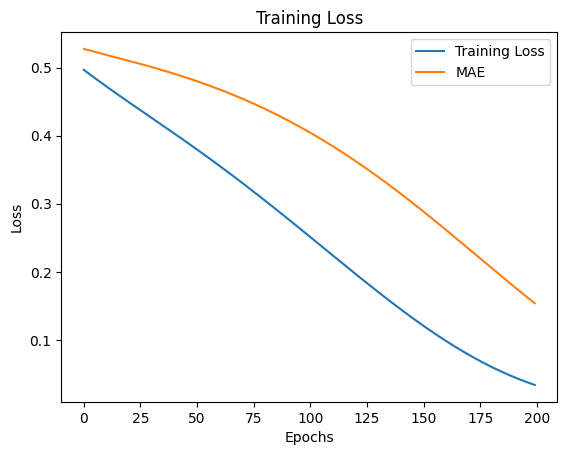

In [214]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['mae'], label='MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

In [215]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0328 - mae: 0.1512
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2098 - mae: 0.4574


[0.20980201661586761, 0.45738136768341064]

In [216]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = np.array([scaler.inverse_transform(
	np.hstack([predict.reshape(-1, 1), np.zeros((predict.shape[0], dataset_train.shape[1] - 1))])
)[:, 0] for predict in train_predict]).tolist()
test_predict = np.array([scaler.inverse_transform(
	np.hstack([predict.reshape(-1, 1), np.zeros((predict.shape[0], dataset_train.shape[1] - 1))])
)[:, 0] for predict in test_predict]).tolist()
train_predict, test_predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


([[-9.12971088642499], [2.793240098233561]], [[-0.6592932996876235]])

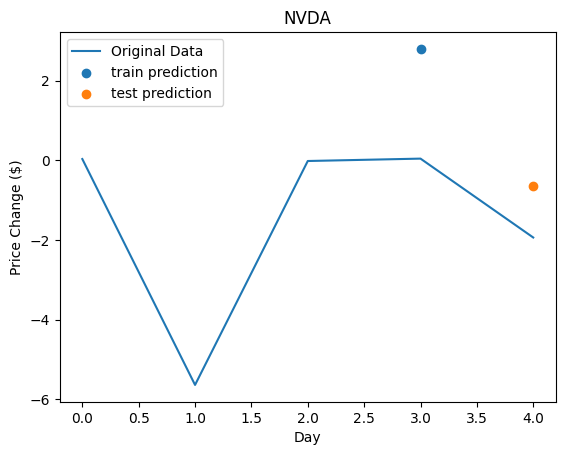

In [219]:
plt.plot(np.arange(len(results_df["change"])), results_df["change"], label="Original Data")
# for i in range(0, len(train_predict), forecast_steps):
#   plt.plot(np.arange(i+look_back, i+look_back+forecast_steps), train_predict[i])
# for i in range(0, len(test_predict), forecast_steps):
#   plt.plot(np.arange(len(train_predict) + i+2*look_back+forecast_steps, len(train_predict) + i+2*look_back+2*forecast_steps), test_predict[i])
plt.scatter(3, train_predict[1], label="train prediction")
plt.scatter(4, test_predict[0], label="test prediction")
plt.legend()
plt.xlabel('Day')
plt.ylabel('Price Change ($)')
plt.title('NVDA')
plt.show()